# Análise Exploratória dos Dados (EDA)
Primeiro, vamos importar as bibliotecas necessárias e carregar os dados.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import ipywidgets as widgets
from ipywidgets import interact

In [2]:
# Carregar o dataset
df = pd.read_csv('desafio_indicium_imdb.csv', index_col=0)

# Mostrar as primeiras linhas do dataset
df.head()

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
1,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
3,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
4,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"
5,The Lord of the Rings: The Return of the King,2003,U,201 min,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,"377,845,905"


### Análise de Valores Faltantes
Verificar se há valores faltantes no dataset.

In [3]:
# Mostrar informações básicas do dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 999 entries, 1 to 999
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series_Title   999 non-null    object 
 1   Released_Year  999 non-null    object 
 2   Certificate    898 non-null    object 
 3   Runtime        999 non-null    object 
 4   Genre          999 non-null    object 
 5   IMDB_Rating    999 non-null    float64
 6   Overview       999 non-null    object 
 7   Meta_score     842 non-null    float64
 8   Director       999 non-null    object 
 9   Star1          999 non-null    object 
 10  Star2          999 non-null    object 
 11  Star3          999 non-null    object 
 12  Star4          999 non-null    object 
 13  No_of_Votes    999 non-null    int64  
 14  Gross          830 non-null    object 
dtypes: float64(2), int64(1), object(12)
memory usage: 124.9+ KB


### Conversão de variáveis e tratamento da base de dados
Abaixo são feitos alguns tratamentos, como a remoção de linhas duplicadas e a conversão de colunas com valores numéricos importantes que inicialmente na base de dados estavam classificadas como categóricas. 

In [4]:
# Remover linhas duplicadas
df = df.drop_duplicates()

In [5]:
# Converter colunas para o tipo numérico quando apropriado
df['Released_Year'] = pd.to_numeric(df['Released_Year'], errors='coerce')
df['Meta_score'] = pd.to_numeric(df['Meta_score'], errors='coerce')
df['IMDB_Rating'] = pd.to_numeric(df['IMDB_Rating'], errors='coerce')
df['No_of_Votes'] = pd.to_numeric(df['No_of_Votes'], errors='coerce')

# Função para converter Runtime apenas em minutos
def convert_runtime(runtime_str):
    # Remove ' min' e converte para int
    minutes = int(runtime_str.replace(' min', ''))
    return minutes  # Retorna apenas o número de minutos como inteiro

# Aplica a função de conversão à coluna Runtime
df['Runtime'] = df['Runtime'].apply(convert_runtime)

# Remover caracteres não numéricos da coluna 'Gross' e converter para float essa coluna de faturamento
df['Gross'] = df['Gross'].replace('[\$,]', '', regex=True).astype(float)


**Após isso, é iniciado o tratamento dos valores nulos da base de dados.**

Inicialmente é feito a proporção de valores nulos em cada coluna.

In [6]:
# Calcular a proporção de valores nulos em cada coluna
null_proportion = df.isnull().mean() * 100

# Exibir a proporção de valores nulos
print(null_proportion)

Series_Title      0.000000
Released_Year     0.100100
Certificate      10.110110
Runtime           0.000000
Genre             0.000000
IMDB_Rating       0.000000
Overview          0.000000
Meta_score       15.715716
Director          0.000000
Star1             0.000000
Star2             0.000000
Star3             0.000000
Star4             0.000000
No_of_Votes       0.000000
Gross            16.916917
dtype: float64


Inicialmente é feito a exclusão da única linha nula da coluna 'Released_Year', como podemos ver na proporção de valores nulos acima, a exclusão dessa única linha não trará perca de informação da base de dados em todo o processo exploratório e preditivo que farei.

In [7]:
# Excluir linhas nulas na coluna Released Year, que no caso só possui uma linha nula
df = df.dropna(subset=['Released_Year'])

Logo, para colunas, como a de faturamento 'Gross' e a de 'Meta_score', a decisão sobre excluir valores nulos de um DataFrame depende de vários fatores, incluindo a proporção de valores ausentes, o impacto potencial dessa exclusão na análise e a natureza dos dados.

Mas tem umas orientações mais gerais que a comunidade no geral segue, sendo elas:

Baixa Proporção de Valores Nulos: Se menos de 5% dos dados estão ausentes, geralmente é seguro excluir esses valores sem afetar significativamente a análise.

Proporção Moderada de Valores Nulos (5-20%): Nessa faixa, a decisão depende do contexto e da importância das variáveis com valores ausentes. Substituir valores nulos por uma estatística (média, mediana, moda) ou usando técnicas de imputação pode ser mais adequado.

Alta Proporção de Valores Nulos (>20%): Se mais de 20% dos dados estão ausentes, excluir esses valores pode resultar na perda de informações importantes. Nesse caso, técnicas de imputação ou modelagem para lidar com valores ausentes são recomendadas.

A coluna **'Meta_score'** por exemplo, possui uma proporção de mais de 15% de valores nulos. Logo, excluir todas as linhas nulas dessa coluna pode causar uma grande perca de informação dos dados. Então, nesse caso, substituir valores nulos por uma estatística (média, mediana, moda) pode ser mais adequado.

Então, para tentar compreender qual substituição é mais devida para essa coluna, utilizaremos visualizações analíticas para auxiliar nessa escolha.

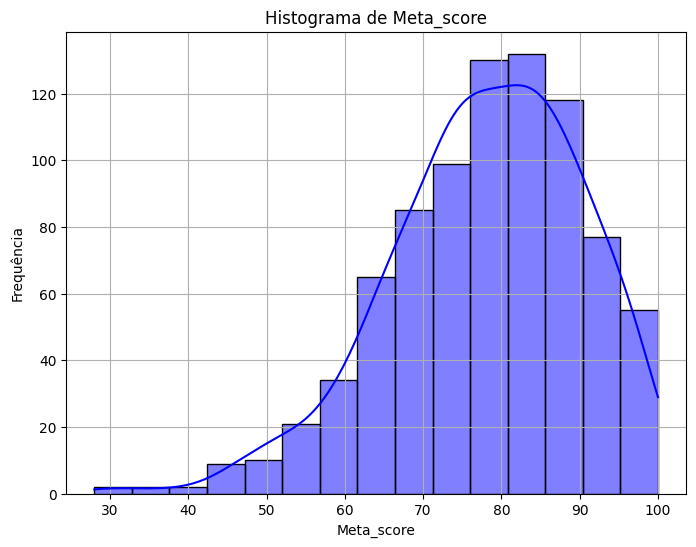

In [8]:
# Plotar o histograma de Meta_score
plt.figure(figsize=(8, 6))
sns.histplot(df['Meta_score'].dropna(), bins=15, kde=True, color='blue', edgecolor='black')
plt.title('Histograma de Meta_score')
plt.xlabel('Meta_score')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

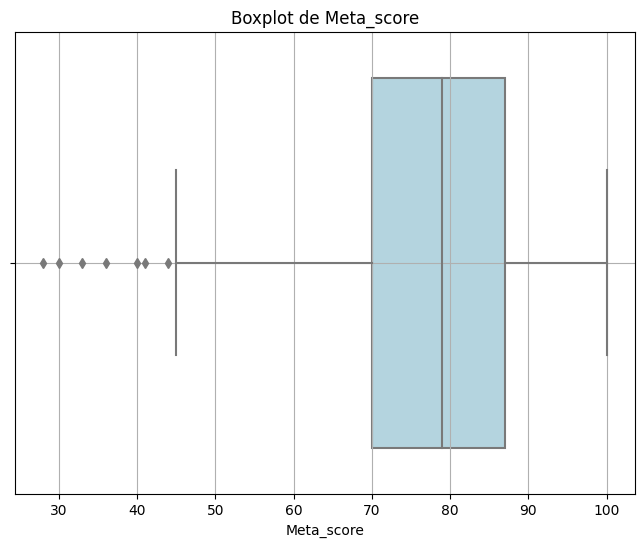

In [9]:
# Plotar o boxplot de Meta_score
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['Meta_score'], color='lightblue')
plt.title('Boxplot de Meta_score')
plt.xlabel('Meta_score')
plt.grid(True)
plt.show()

A análise do histograma revela que a coluna **'Meta_score'** exibe uma distribuição normalizada de seus valores. Portanto, optaremos por utilizar a **média** para substituição de dados faltantes, como observado. Além disso, conforme indicado pelo boxplot, a média e a mediana são aproximadamente iguais, reforçando que a média é uma estimativa confiável para valores ausentes.


In [10]:
# Calcular a média da coluna Meta_score
mean_meta = df['Meta_score'].mean()

# Imputar valores nulos com a mediana
df['Meta_score'].fillna(mean_meta, inplace=True)

# Verificar se os valores nulos foram preenchidos
print(df['Meta_score'].isnull().sum())

0


Já a coluna **'Gross'**, possui uma proporção de mais de 16% de valores nulos. Como falado anteriormente, excluir todas as linhas nulas pode causar uma grande perca de informação dos dados, podendo impossibilitar no processo exploratório e preditivo, entendimentos importantes sobre os dados.

Sendo assim, para dá continuidade à análise exploratória, os valores nulos da coluna **Gross** que representa valores financeiros e pode ter uma distribuição assimétrica com muitos outliers (alguns filmes têm faturamentos extremamente altos em comparação com a maioria), serão substituídos pela **mediana**, que é normalmente a **melhor** escolha para esses valores financeiros.

In [11]:
# Calcular a mediana da coluna 'Gross'
median_gross = df['Gross'].median()

# Imputar valores nulos com a mediana
df['Gross'].fillna(median_gross, inplace=True)

# Verificar se os valores nulos foram preenchidos
print(df['Gross'].isnull().sum())

0


### Resumo Estatístico
Resumo criado com o objetivo de proporcionar uma visão geral das variáveis numéricas após todos os tratamentos aplicados, contribuindo para um melhor entendimento prévio da base de dados.

In [12]:
# Resumo estatístico
df.describe()

,Released_Year,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross
count,998.000000,998.000000,998.000000,998.000000,9.980000e+02,9.980000e+02
mean,1991.214429,122.854709,7.948297,77.970273,2.716239e+05,6.040741e+07
std,23.308539,28.110078,0.272203,11.373228,3.210735e+05,1.014613e+08
min,1920.000000,45.000000,7.600000,28.000000,2.508800e+04,1.305000e+03
25%,1976.000000,103.000000,7.700000,72.000000,5.541675e+04,5.010758e+06
50%,1999.000000,119.000000,7.900000,77.970273,1.381685e+05,2.338399e+07
75%,2009.000000,136.750000,8.100000,85.750000,3.735062e+05,6.144663e+07
max,2020.000000,321.000000,9.200000,100.000000,2.303232e+06,9.366622e+08


### Análises Exploratórias
Aqui é iniciado todo o processo de análise exploratória dos dados, com o objetivo de apresentar e analisar os dados, gerar insights, gerar hipóteses e responder questionamentos.  
#### Distribuição das Avaliações IMDb

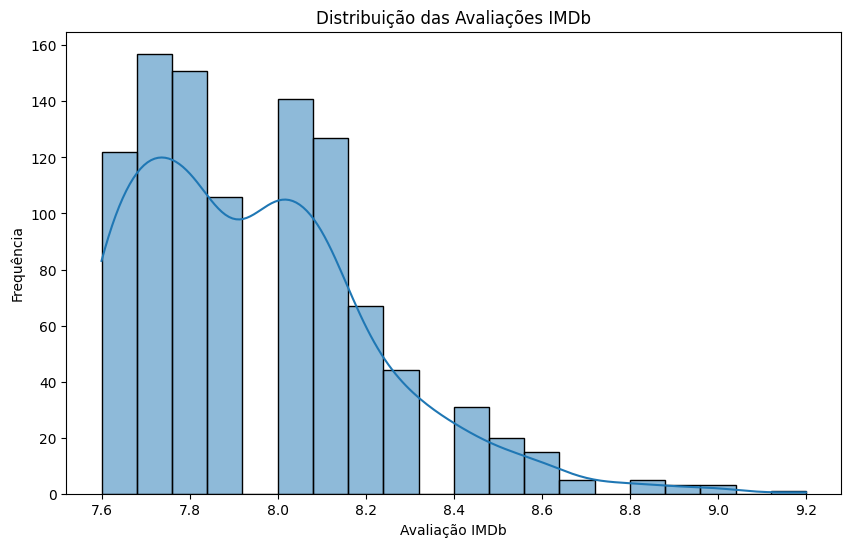

In [13]:
# Distribuição das avaliações IMDb
plt.figure(figsize=(10, 6))
sns.histplot(df['IMDB_Rating'], bins=20, kde=True)
plt.title('Distribuição das Avaliações IMDb')
plt.xlabel('Avaliação IMDb')
plt.ylabel('Frequência')
plt.show()

#### Distribuição da Receita Bruta

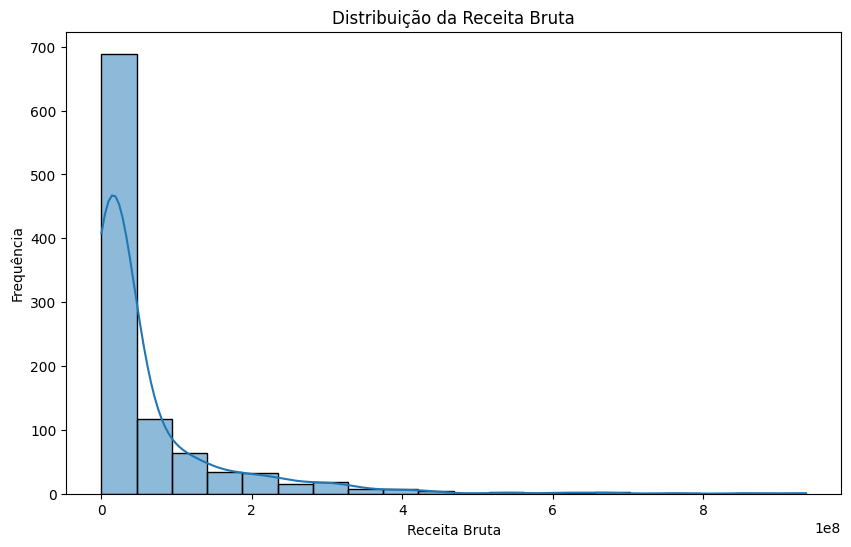

In [14]:
# Distribuição da receita bruta
plt.figure(figsize=(10, 6))
sns.histplot(df['Gross'], bins=20, kde=True)
plt.title('Distribuição da Receita Bruta')
plt.xlabel('Receita Bruta')
plt.ylabel('Frequência')
plt.show()

#### Avaliação IMDb vs Receita Bruta

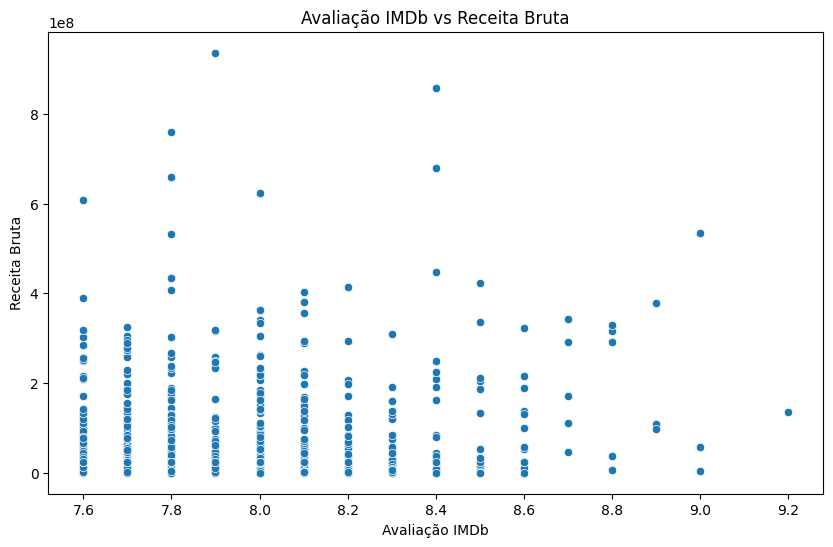

In [15]:
# Avaliação IMDb vs Receita Bruta
plt.figure(figsize=(10, 6))
sns.scatterplot(x='IMDB_Rating', y='Gross', data=df)
plt.title('Avaliação IMDb vs Receita Bruta')
plt.xlabel('Avaliação IMDb')
plt.ylabel('Receita Bruta')
plt.show()

Analisando as três visualizações construídadas acima, percebe-se que aparentemente:

- Filmes com altas avaliações não garantem altas receitas e vice-versa. A receita bruta parece ser influenciada por outros fatores além da qualidade percebida pelo público (como marketing, franquias, e público-alvo).
- A concentração das avaliações IMDb sugere que a maioria dos filmes são medianamente bem recebidos pelo público, com uma pequena porcentagem sendo excepcionalmente bem ou mal avaliados.
- Apenas um pequeno número de filmes alcança receitas extremamente altas, indicando que atingir altos níveis de receita bruta é raro e possivelmente dependente de fatores como grandes orçamentos, franquias estabelecidas, ou marketing intensivo.

#### Anos de lançamentos dos filmes
Outro fator interessante, é analisar as características das produções de filmes no decorrer dos anos.

Para se ter uma análise mais geral e não tão poluída, iremos construir visualizações analíticas levando em conta as décadas de lançamento.  

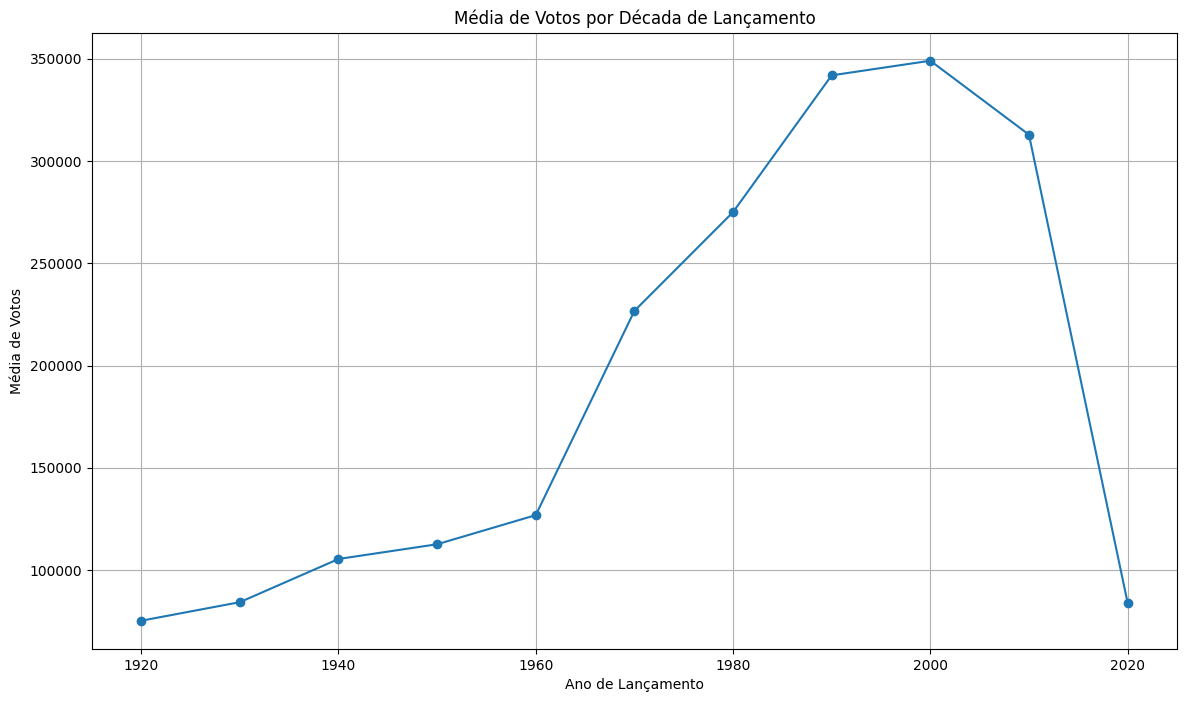

In [16]:
# Calcular a média de votos por ano de lançamento
avg_votes_per_year = df.groupby('Released_Year')['No_of_Votes'].mean()

# Agrupar os dados por década
avg_votes_per_decade = avg_votes_per_year.groupby((avg_votes_per_year.index // 10) * 10).mean()

# Criar o gráfico de linha
plt.figure(figsize=(14, 8))
plt.plot(avg_votes_per_decade.index, avg_votes_per_decade.values, marker='o')
plt.title('Média de Votos por Década de Lançamento')
plt.xlabel('Ano de Lançamento')
plt.ylabel('Média de Votos')
plt.grid(True)
plt.show()

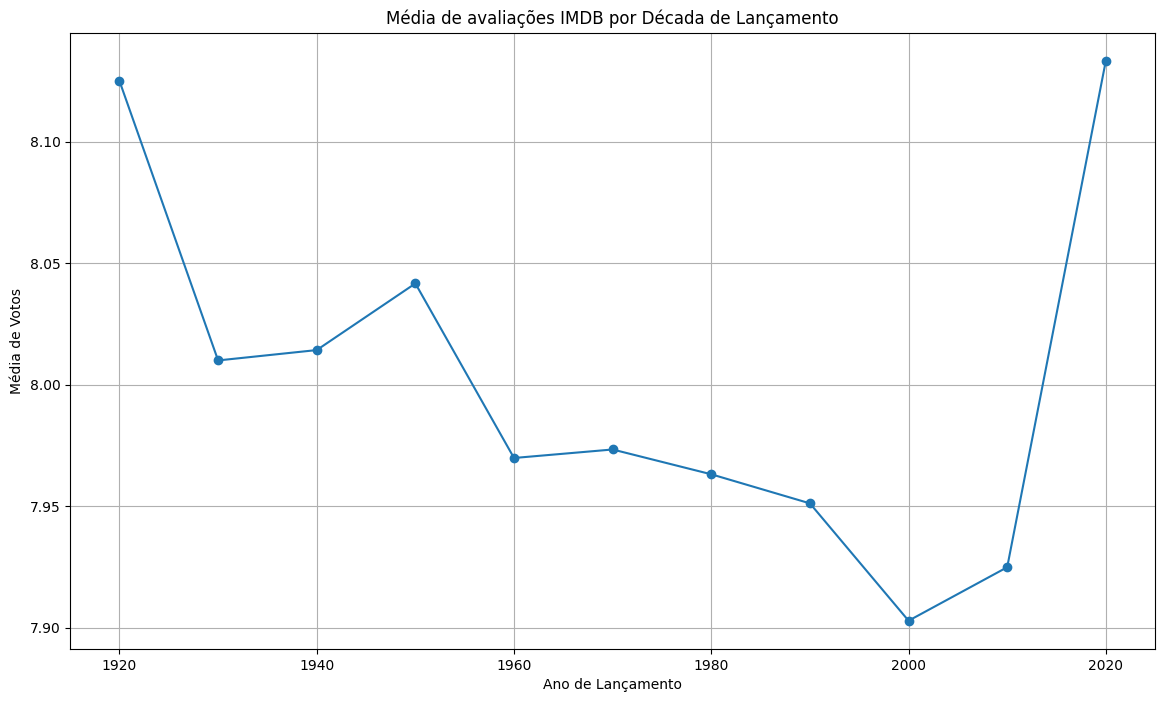

In [17]:
# Calcular a média de votos por ano de lançamento
avg_imdb_per_year = df.groupby('Released_Year')['IMDB_Rating'].mean()

# Agrupar os dados por década
avg_imdb_per_decade = avg_imdb_per_year.groupby((avg_imdb_per_year.index // 10) * 10).mean()

# Criar o gráfico de linha
plt.figure(figsize=(14, 8))
plt.plot(avg_imdb_per_decade.index, avg_imdb_per_decade.values, marker='o')
plt.title('Média de avaliações IMDB por Década de Lançamento')
plt.xlabel('Ano de Lançamento')
plt.ylabel('Média de Votos')
plt.grid(True)
plt.show()

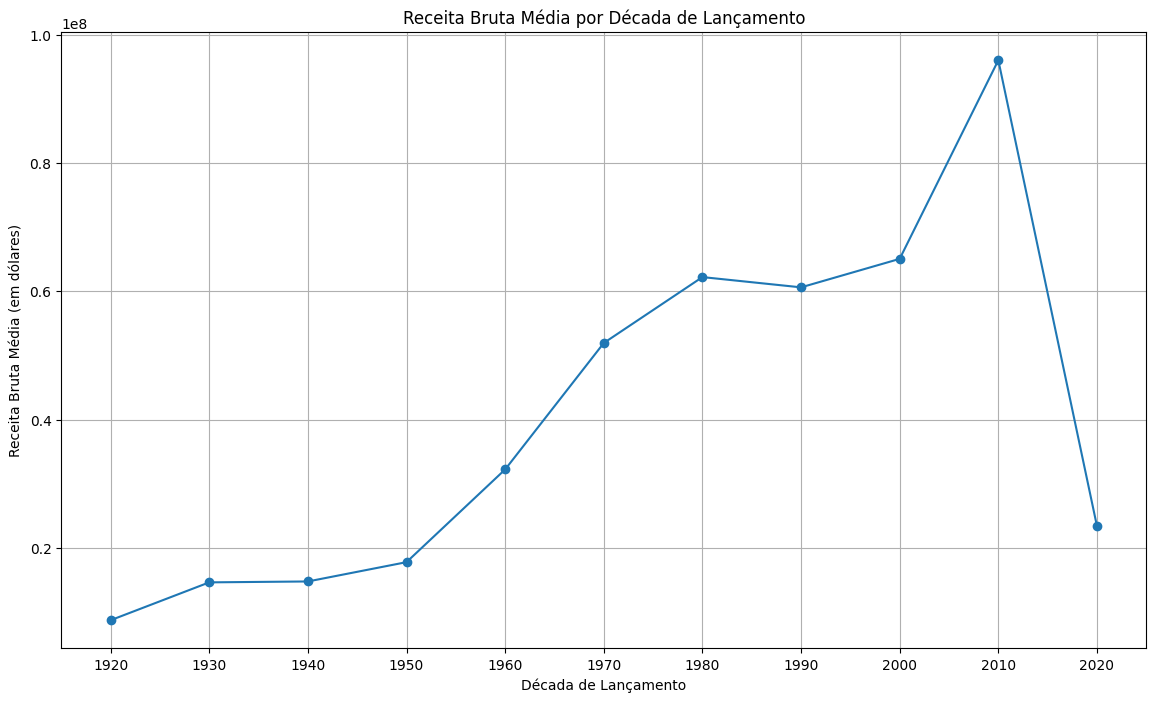

In [18]:
# Calcular a receita bruta média por ano de lançamento
avg_gross_per_year = df.groupby('Released_Year')['Gross'].mean()

# Agrupar os dados por década
avg_gross_per_decade = avg_gross_per_year.groupby((avg_gross_per_year.index // 10) * 10).mean()

# Criar o gráfico de linha
plt.figure(figsize=(14, 8))
plt.plot(avg_gross_per_decade.index, avg_gross_per_decade.values, marker='o')
plt.title('Receita Bruta Média por Década de Lançamento')
plt.xlabel('Década de Lançamento')
plt.ylabel('Receita Bruta Média (em dólares)')
plt.grid(True)
plt.xticks(avg_gross_per_decade.index)  # Definir as décadas como rótulos do eixo x
plt.show()

Tendo como base as visualizações apresentadas anteriormente, podemos perceber alguns comportamentos interessantes, com:

1. Primeiro, vamos analisar as décadas **antes da virada do século**, ou seja, antes dos anos 2000:
- A partir da década de 60 há um grande crescimento nos faturamentos dos filmes lançados. Isso provavelmente ocorreu, por que a partir dessa década foram produzidos filmes bem impactantes e que marcaram gerações, como:
	* Bonequinha de Luxo / *Breakfast at Tiffany's* (1961)
	* A Noviça Rebelde / *The Sound of Music* (1965)
	* Era uma Vez no Oeste / *Once Upon a Time in the West* (1968)
	* A trilogia O Poderoso Chefão / *The Godfather* (1972)
	* O exorcista / *The exorcist* (1973)
	* Tubarão / *Jaws* (1975)
	* A saga Guerra nas Estrelas / *Star Wars* (1977)
- Para reforçar e embasar esta ideia, podemos pegar o gráfico apresentando **abaixo** sobre essa época, em que traz os **Top Filmes**, que foram sucessos de faturamento e de avaliação de 1960 a 1980. Podemos ver que os filmes citados na lista acima estão em destaque nos **Top Filmes**. 
- Além disso, esses filmes estão sempre sendo citados em listas de sites importantes como filmes que marcaram épocas. Segue abaixo algumas listas:
	* https://canaltech.com.br/entretenimento/melhores-filmes-anos-1960-176341/
	* https://www.adorocinema.com/filmes/melhores/decada-1980/


##### Top Filmes Receita/Melhor Avaliação (1960-1980)

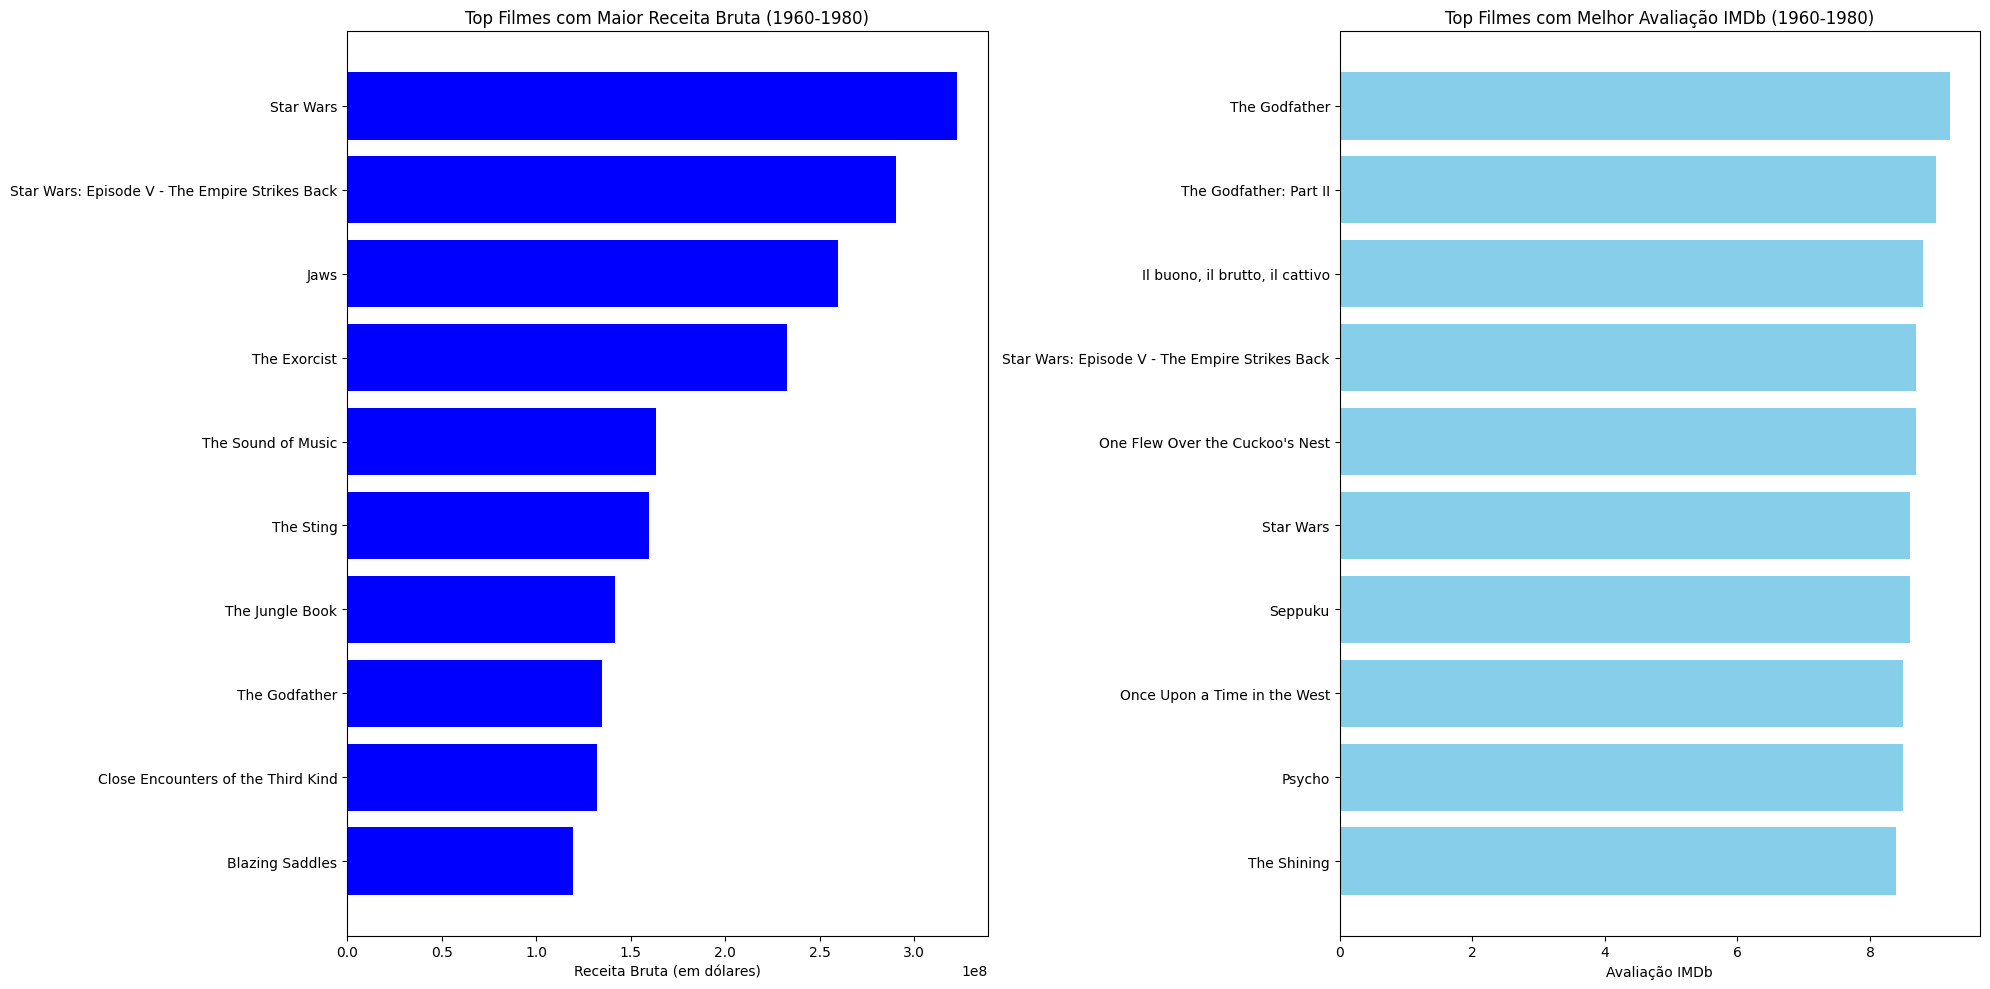

In [19]:
# Filtrar os filmes entre 1960 e 1980
df_1960s_1980s = df[(df['Released_Year'] >= 1960) & (df['Released_Year'] <= 1980)]

# Selecionar os 10 filmes com maior receita bruta
top_10_grossing_1960_1980 = df_1960s_1980s.nlargest(10, 'Gross')

# Selecionar os 10 filmes com melhor avaliação IMDb
top_10_rated_1960_1980 = df_1960s_1980s.nlargest(10, 'IMDB_Rating')

# Configurar o layout dos subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# Gráfico dos 10 filmes com maior receita bruta
axes[0].barh(top_10_grossing_1960_1980['Series_Title'], top_10_grossing_1960_1980['Gross'], color='blue')
axes[0].set_xlabel('Receita Bruta (em dólares)')
axes[0].set_title('Top Filmes com Maior Receita Bruta (1960-1980)')
axes[0].invert_yaxis()  # Inverter o eixo y para mostrar o maior no topo

# Gráfico dos 10 filmes com melhor avaliação IMDb
axes[1].barh(top_10_rated_1960_1980['Series_Title'], top_10_rated_1960_1980['IMDB_Rating'], color='skyblue')
axes[1].set_xlabel('Avaliação IMDb')
axes[1].set_title('Top Filmes com Melhor Avaliação IMDb (1960-1980)')
axes[1].invert_yaxis()  # Inverter o eixo y para mostrar o maior no topo

# Ajustar layout
plt.tight_layout()
plt.show()

2. Agora, vamos analisar as décadas após a virada de século, mais especificamente entre **2000 e 2020 (último ano com dados registrados na base)**:
- Com o ínicio dos anos 2000, o faturamento continuou subindo e também a quantidade de votos (Avanço da tecnologia que facilitou o acesso das pessoas no geral à internet, por exemplo). Esse grande crescimento de faturamento e de popularidade estão relacionados com alguns fatores, sendo eles:

	* De 2000 a 2020, a indústria cinematográfica testemunhou transformações significativas, com o surgimento de novas tendências e a consolidação de gêneros específicos. Entre esses, os filmes de heróis ganharam destaque, culminando em produções de grande faturamento como "Avatar". 

	* **Ascensão dos Filmes de Heróis e de outros Filmes Marcantes**:
	
		Os Vingadores: Ultimato (2019): Sucesso de bilheteria e aclamação do público;

		Star Wars: O Despertar da Força - VII (2015): O retorno de Star Wars que gerou um faturamento e uma aclamação intensa;

		Cavaleiro das Trevas/The Dark Knight (2008): Um dos filmes mais marcantes feitos do batman e com um sucesso de bilheteria e avaliação.

		Senhor dos Anéis (Retorno do Rei)/ The Lord of the Rings (Return of the King) (2003) - Trilogia dos anéis, magos e hobbits que marcaram gerações e que são sucesso de faturamento e avaliação. 
	* **Fatores de Sucesso**:
			Efeitos Visuais e Tecnologia: Avanços em CGI (Computer-Generated Imagery) permitiram a criação de cenas de ação e efeitos especiais impressionantes.
			Narrativas Interconectadas: O conceito de universos compartilhados manteve o público engajado ao longo de várias franquias.
	* **Inovação Tecnológica**:
			Lançado em 2009, **Avatar** foi revolucionário em termos de tecnologia cinematográfica. Dirigido por James Cameron, o filme utilizou tecnologia 3D e captura de movimento de maneiras inéditas, criando um mundo visualmente deslumbrante que encantou audiências globais.
- Para reforçar e embasar essa ideia, podemos analisar o gráfico apresentado **abaixo**, que mostra os **Top Filmes** que foram sucessos de faturamento e avaliação de 2000 a 2020. É evidente que os filmes citados acima estão entre os destaques nos **Top Filmes** construídos. 

**Segue abaixo as referências que embasou a análise construída acima:**
- https://www.adorocinema.com/noticias/filmes/noticia-161946/
- https://www.nytimes.com/2009/12/18/movies/18avatar.html
- https://www.bbc.com/news/entertainment-arts-43931928
- https://www.disney.com.br/novidades/avatar-todos-os-filmes-e-especiais-do-incrivel-universo-criado-por-james-cameron
- https://jovemnerd.com.br/noticias/filmes/por-que-avatar-mudou-o-cinema
- https://www.nerdstickers.com.br/batman-o-cavaleiro-das-trevas/
- https://pt.quora.com/Como-entender-o-sucesso-e-influ%C3%AAncia-de-O-Senhor-dos-An%C3%A9is
- https://www.adorocinema.com/filmes/filme-215097/

##### Top Filmes Receita/Melhor Avaliação (2000-2020)

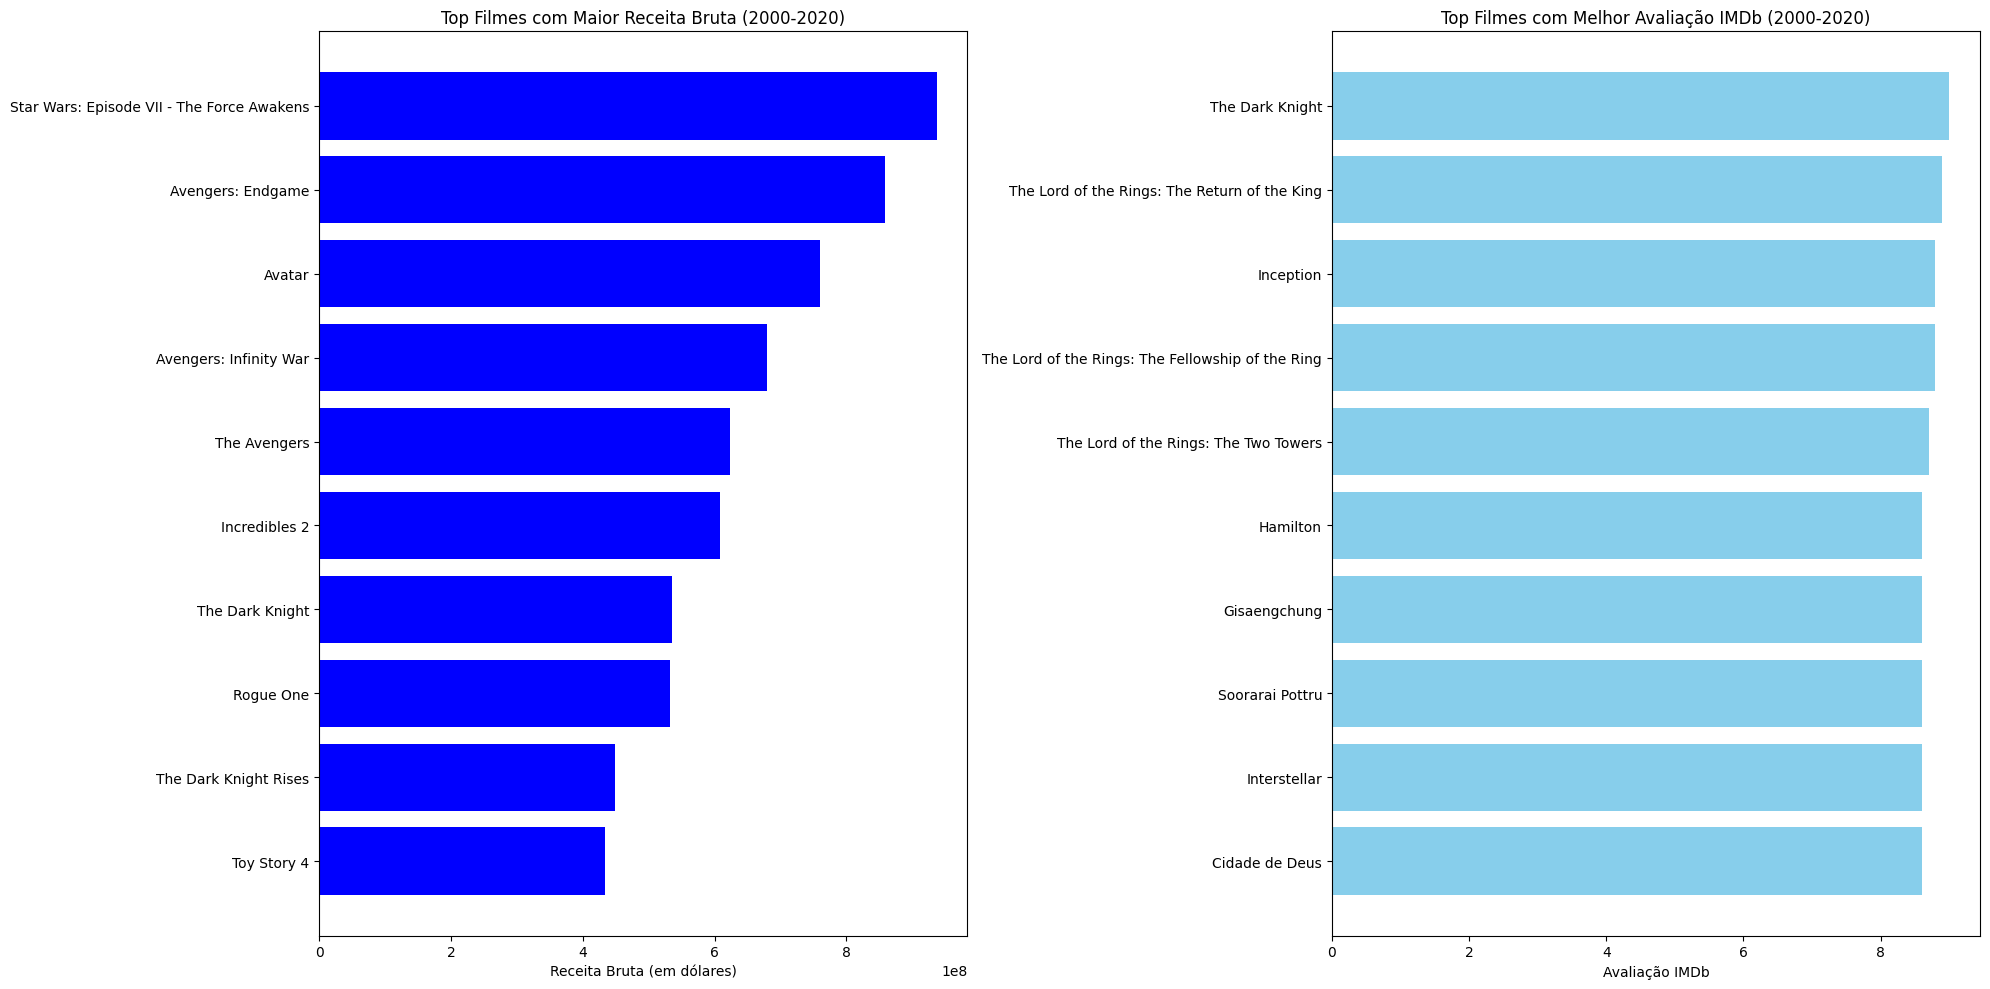

In [20]:
# Filtrar os filmes entre 2000 e 2020
df_2000s_2020s = df[(df['Released_Year'] >= 2000) & (df['Released_Year'] <= 2020)]

# Selecionar os 10 filmes com maior receita bruta
top_10_grossing_2000_2020 = df_2000s_2020s.nlargest(10, 'Gross')

# Selecionar os 10 filmes com melhor avaliação IMDb
top_10_rated_2000_2020 = df_2000s_2020s.nlargest(10, 'IMDB_Rating')

# Configurar o layout dos subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# Gráfico dos 10 filmes com maior receita bruta
axes[0].barh(top_10_grossing_2000_2020['Series_Title'], top_10_grossing_2000_2020['Gross'], color='blue')
axes[0].set_xlabel('Receita Bruta (em dólares)')
axes[0].set_title('Top Filmes com Maior Receita Bruta (2000-2020)')
axes[0].invert_yaxis()  # Inverter o eixo y para mostrar o maior no topo

# Gráfico dos 10 filmes com melhor avaliação IMDb
axes[1].barh(top_10_rated_2000_2020['Series_Title'], top_10_rated_2000_2020['IMDB_Rating'], color='skyblue')
axes[1].set_xlabel('Avaliação IMDb')
axes[1].set_title('Top Filmes com Melhor Avaliação IMDb (2000-2020)')
axes[1].invert_yaxis()  # Inverter o eixo y para mostrar o maior no topo

# Ajustar layout
plt.tight_layout()
plt.show()

In [21]:
'''# Explodir os gêneros em linhas separadas
df_exploded = df.assign(Genre=df['Genre'].str.split(', ')).explode('Genre')

# Contar o número de filmes de cada gênero por ano
genre_per_year = df_exploded.groupby(['Released_Year', 'Genre']).size().unstack().fillna(0)

# Função para plotar gráfico de área empilhada de um gênero específico
def plot_genre_area(selected_genre):
    plt.figure(figsize=(14, 8))
    if selected_genre == 'Todos':
        genre_per_year.plot(kind='area', stacked=True, figsize=(14, 8), alpha=0.7)
    else:
        genre_per_year[[selected_genre]].plot(kind='area', stacked=True, figsize=(14, 8), alpha=0.7)
    plt.title(f'Evolução do Gênero "{selected_genre}" ao Longo dos Anos' if selected_genre != 'Todos' else 'Evolução dos Gêneros de Filmes ao Longo dos Anos')
    plt.xlabel('Ano de Lançamento')
    plt.ylabel('Número de Filmes')
    plt.legend(title='Gênero', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

# Criação do widget de seleção de gênero
genre_options = ['Todos'] + list(genre_per_year.columns)
interact(plot_genre_area, selected_genre=widgets.Dropdown(options=genre_options, description='Gênero:'))'''

'# Explodir os gêneros em linhas separadas\ndf_exploded = df.assign(Genre=df[\'Genre\'].str.split(\', \')).explode(\'Genre\')\n\n# Contar o número de filmes de cada gênero por ano\ngenre_per_year = df_exploded.groupby([\'Released_Year\', \'Genre\']).size().unstack().fillna(0)\n\n# Função para plotar gráfico de área empilhada de um gênero específico\ndef plot_genre_area(selected_genre):\n    plt.figure(figsize=(14, 8))\n    if selected_genre == \'Todos\':\n        genre_per_year.plot(kind=\'area\', stacked=True, figsize=(14, 8), alpha=0.7)\n    else:\n        genre_per_year[[selected_genre]].plot(kind=\'area\', stacked=True, figsize=(14, 8), alpha=0.7)\n    plt.title(f\'Evolução do Gênero "{selected_genre}" ao Longo dos Anos\' if selected_genre != \'Todos\' else \'Evolução dos Gêneros de Filmes ao Longo dos Anos\')\n    plt.xlabel(\'Ano de Lançamento\')\n    plt.ylabel(\'Número de Filmes\')\n    plt.legend(title=\'Gênero\', bbox_to_anchor=(1.05, 1), loc=\'upper left\')\n    plt.grid(Tru

#### Hipóteses Interessantes

1. **Filmes de Gêneros Populares têm Mais Votos?**

- Hipótese: Filmes de gêneros populares (como Ação, Drama, Aventura e Comédia) tendem a ter um maior número de votos no IMDb.

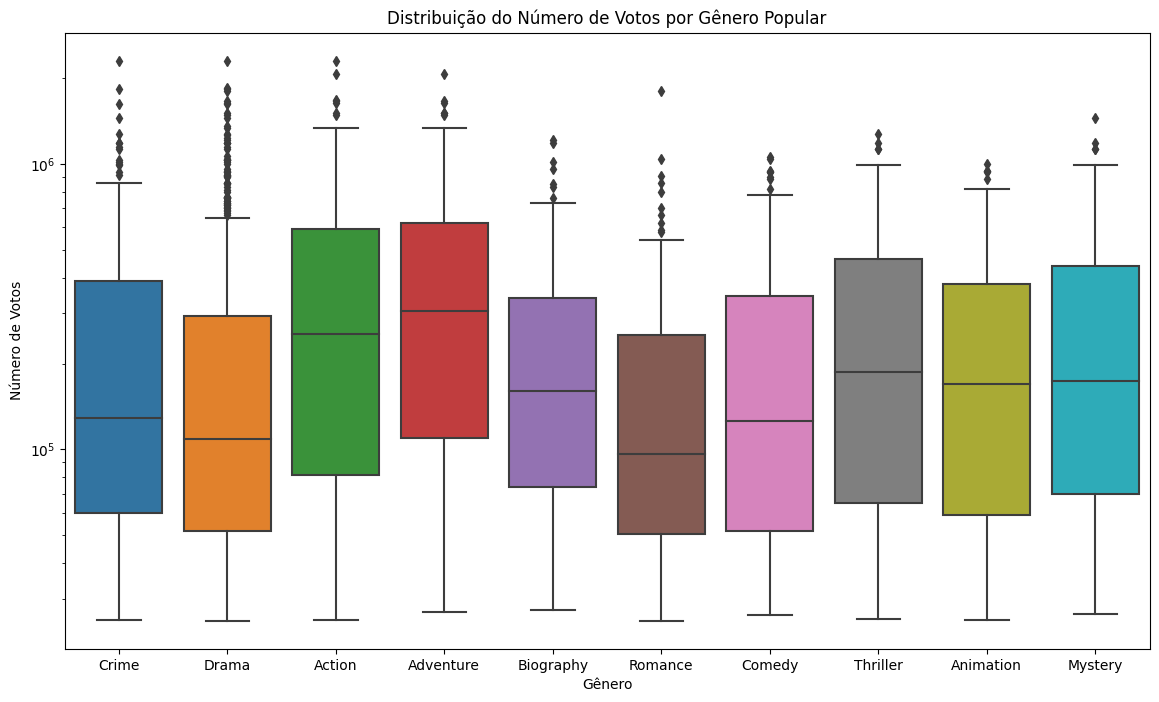

In [22]:
# Explodir os gêneros em linhas separadas
df_exploded = df.assign(Genre=df['Genre'].str.split(', ')).explode('Genre')

# Filtrar os gêneros populares
popular_genres = df_exploded['Genre'].value_counts().head(10).index
df_popular_genres = df_exploded[df_exploded['Genre'].isin(popular_genres)]

# Plotar a distribuição de número de votos por gênero popular
plt.figure(figsize=(14, 8))
sns.boxplot(data=df_popular_genres, x='Genre', y='No_of_Votes')
plt.title('Distribuição do Número de Votos por Gênero Popular')
plt.xlabel('Gênero')
plt.ylabel('Número de Votos')
plt.yscale('log')  # Escala logarítmica para melhor visualização
plt.show()

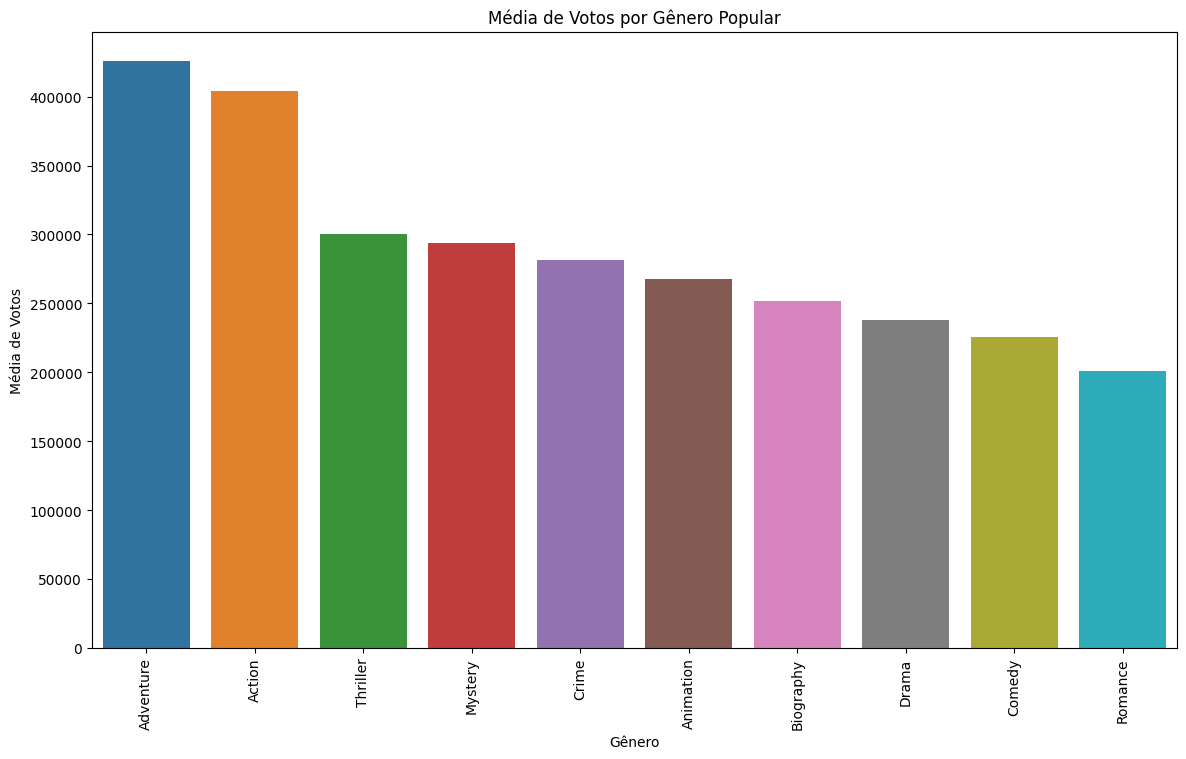

In [23]:
# Calcular a média de votos por gênero
avg_votes_per_genre = df_popular_genres.groupby('Genre')['No_of_Votes'].mean().sort_values(ascending=False)

# Criar o gráfico de barras
plt.figure(figsize=(14, 8))
sns.barplot(x=avg_votes_per_genre.index, y=avg_votes_per_genre.values)
plt.title('Média de Votos por Gênero Popular')
plt.xlabel('Gênero')
plt.ylabel('Média de Votos')
plt.xticks(rotation=90)
plt.show()

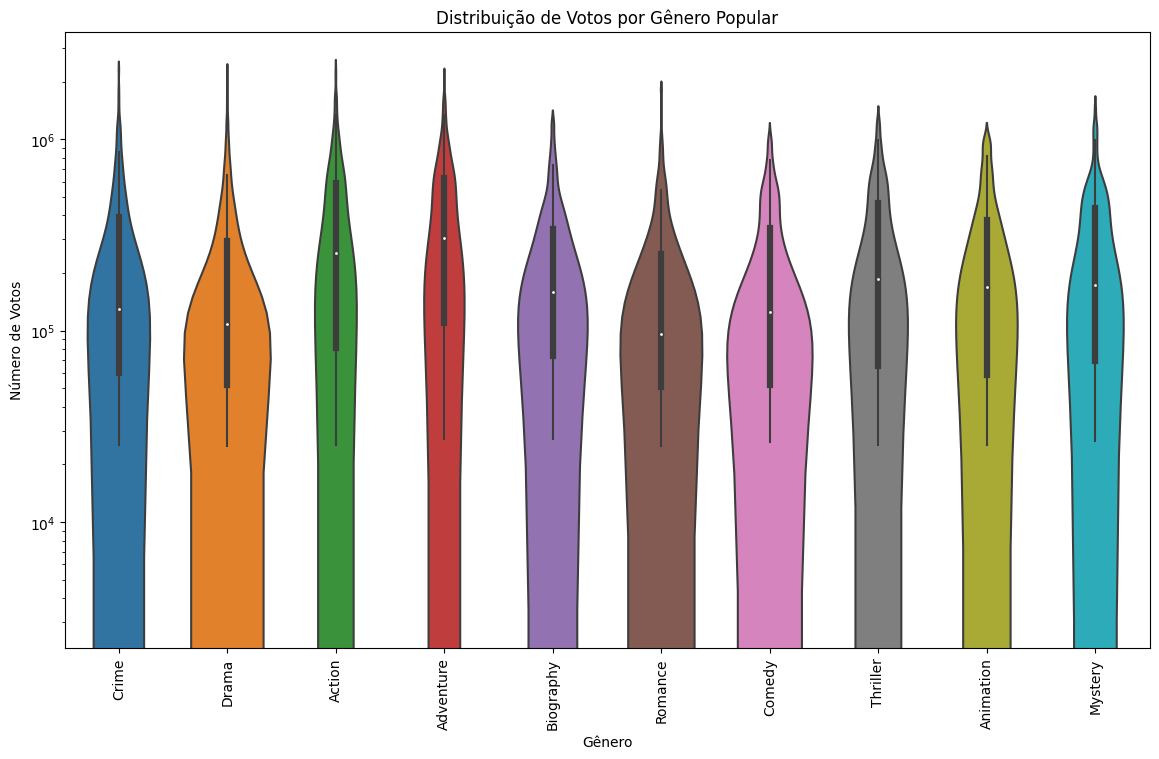

In [38]:
# Criar o gráfico de violino
plt.figure(figsize=(14, 8))
sns.violinplot(data=df_popular_genres, x='Genre', y='No_of_Votes')
plt.title('Distribuição de Votos por Gênero Popular')
plt.xlabel('Gênero')
plt.ylabel('Número de Votos')
plt.yscale('log')  # Escala logarítmica para melhor visualização
plt.xticks(rotation=90)
plt.show()

In [42]:
# Agrupar os dados por gênero e calcular o número total de filmes e votos
genre_votes = df.groupby('Genre').agg(
    total_votes=('No_of_Votes', 'sum'),
    total_movies=('No_of_Votes', 'count')
)

# Calcular a média de votos por filme em cada gênero
genre_votes['avg_votes_per_movie'] = genre_votes['total_votes'] / genre_votes['total_movies']

# Ordenar pelos gêneros com a maior média de votos por filme
genre_votes_sorted = genre_votes.sort_values(by='avg_votes_per_movie', ascending=False)

# Visualizar os resultados
print(genre_votes_sorted)

           total_votes  total_movies  avg_votes_per_movie
Genre                                                    
Sci-Fi        37268246            67        556242.477612
Adventure     83021582           195        425751.702564
Action        76388586           189        404172.412698
Fantasy       22908406            66        347097.060606
Thriller      41106952           137        300050.744526
Mystery       29052873            99        293463.363636
Crime         58796324           209        281322.124402
Animation     21978630            82        268032.073171
Sport          4875755            19        256618.684211
Biography     27456942           109        251898.550459
Drama        171675979           722        237778.364266
Western        4589516            20        229475.800000
Comedy        52533570           233        225465.965665
Family        12514438            56        223472.107143
Horror         6971540            32        217860.625000
Romance       

Violin Plot e Box Plot: Esses gráficos mostram a distribuição dos votos por filme em diferentes gêneros. Podemos observar que alguns gêneros, como Ação, Aventura e Sci-Fi, têm uma maior variação e números de votos mais elevados em comparação a outros gêneros.

Bar Plot (Média de Votos por Gênero): Este gráfico destaca que gêneros como Aventura, Ação, e Sci-Fi têm uma média alta de votos por filme.

Proporção de Votos por Gênero: Este cálculo nos permitiu identificar quais gêneros recebem mais votos em média por filme, corrigindo a possível distorção causada pelo número absoluto de filmes em cada gênero.

**Análise:**

Sci-Fi, Aventura e Ação: Esses gêneros têm as maiores médias de votos por filme, sugerindo que filmes nesses gêneros são populares entre os votantes do IMDb.

Drama e Comédia: Apesar de ter um grande número de filmes (722 para Drama e 233 para Comédia), a média de votos por filme é menor. Isso pode indicar que, embora muitos filmes sejam lançados nesses gêneros, nem todos recebem um grande número de votos, talvez devido à diversidade dentro do próprio gênero.

Outros Gêneros: Gêneros como Romance, Musical, e Film-Noir têm uma média menor de votos por filme, sugerindo menor popularidade entre os votantes.

**Conclusão:**

Confirmação da Hipótese: 

Em geral, a hipótese de que filmes de gêneros populares tendem a ter mais votos no IMDb é confirmada. Gêneros como Ação, Aventura e Sci-Fi estão entre os que têm a maior média de votos por filme.

**Considerações Adicionais:** 

Embora gêneros como Drama e Comédia sejam populares em termos de número de filmes lançados, a média de votos por filme nesses gêneros não é tão alta quanto em gêneros como Ação e Aventura. Isso indica que a popularidade deve ser medida não apenas pelo número de filmes, mas também pela média de votos que os filmes desses gêneros recebem.

2. **Diretores Famosos Geram Mais Receita?**

- Hipótese: Filmes dirigidos por diretores renomados têm maior receita.

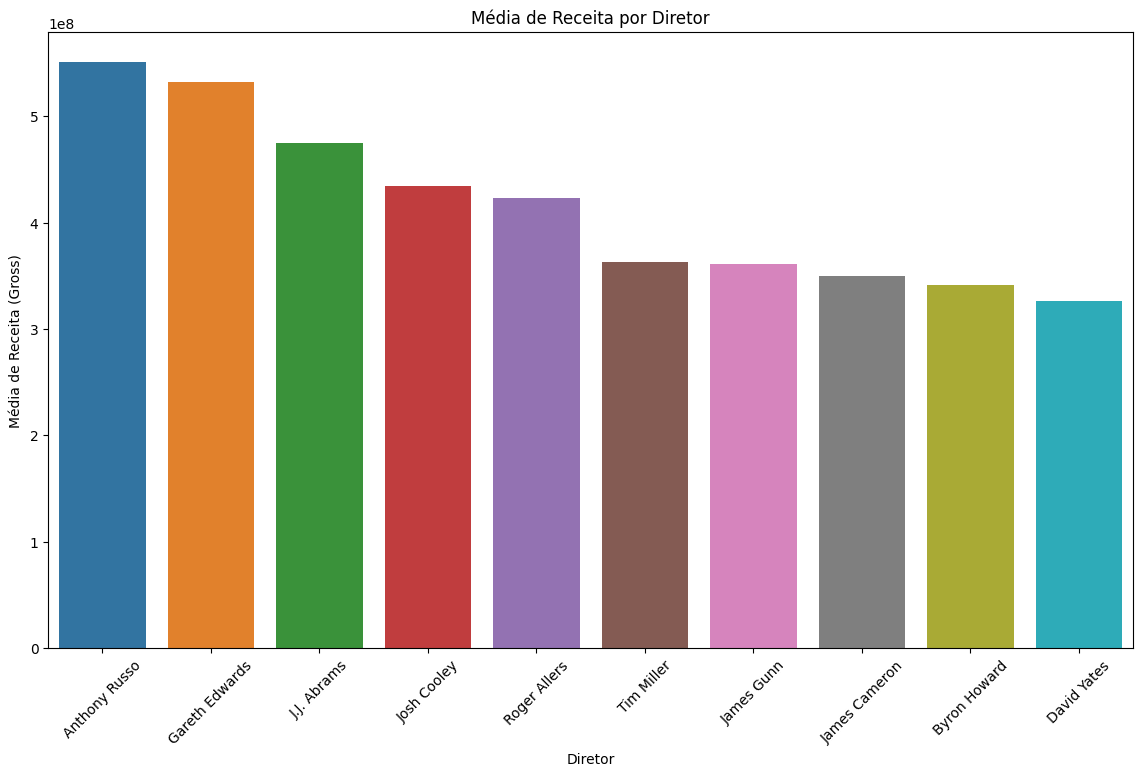

In [25]:
# Agrupar por diretor e calcular a média de receita
avg_gross_per_director = df.groupby('Director')['Gross'].mean().sort_values(ascending=False).head(10)

# Plotar a média de receita por diretor
plt.figure(figsize=(14, 8))
sns.barplot(x=avg_gross_per_director.index, y=avg_gross_per_director.values)
plt.title('Média de Receita por Diretor')
plt.xlabel('Diretor')
plt.ylabel('Média de Receita (Gross)')
plt.xticks(rotation=45)
plt.show()

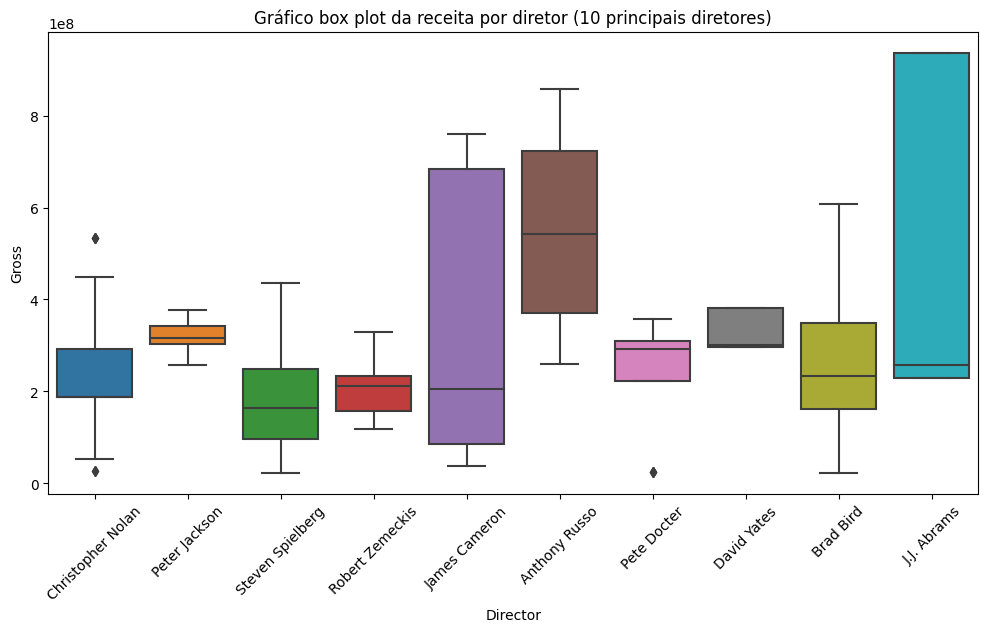

In [62]:
# Calcular a receita total por diretor
total_gross_per_director = df.groupby('Director')['Gross'].sum()

# Selecionar os 10 diretores com maior receita
top_10_directors = total_gross_per_director.nlargest(10).index

# Filtrar o DataFrame original para incluir apenas esses 10 diretores
df_top_10 = df[df['Director'].isin(top_10_directors)]

# Criar o box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Director', y='Gross', data=df_top_10)
plt.xticks(rotation=45)
plt.title('Gráfico box plot da receita por diretor (10 principais diretores)')
plt.show()

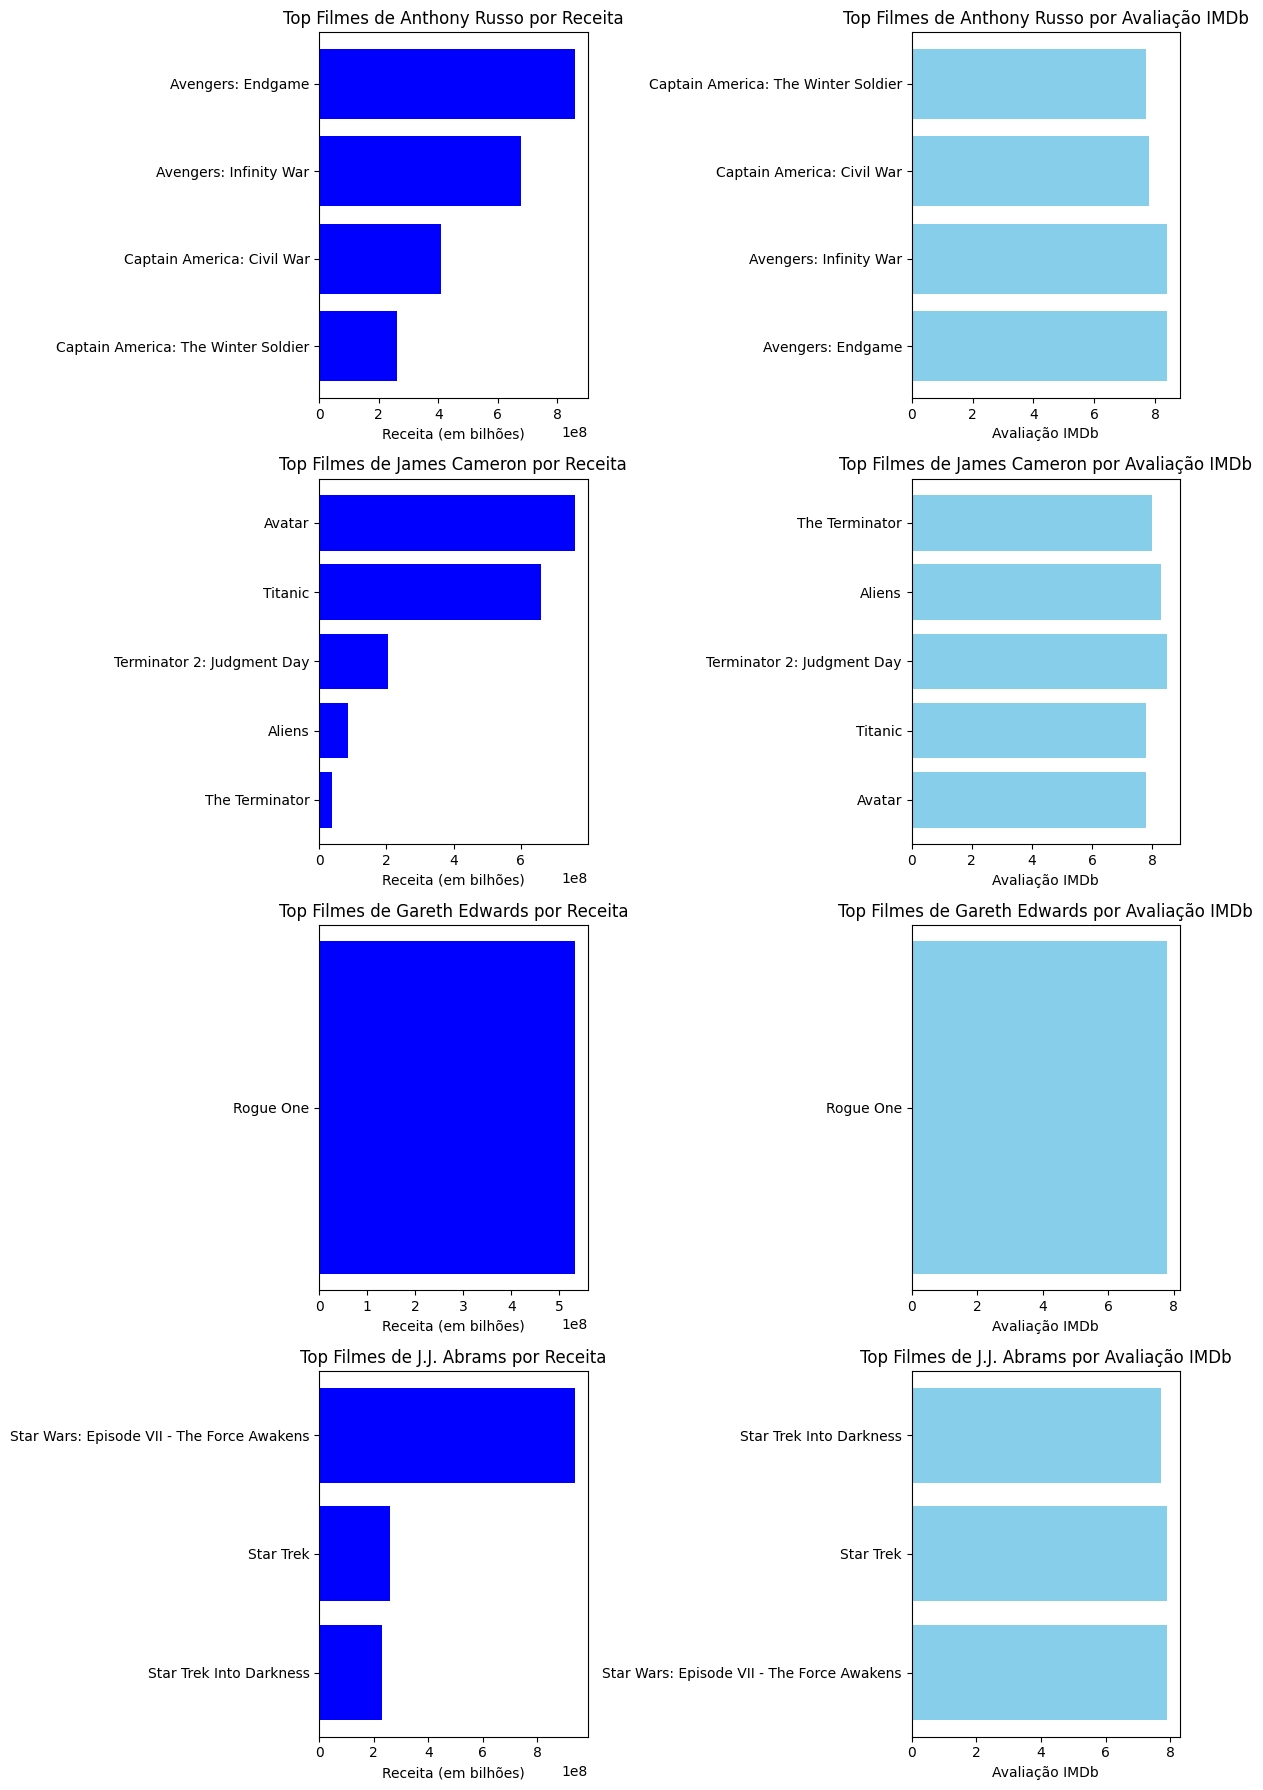

In [66]:
# Filtrar dados para os diretores mencionados
directors = ['Anthony Russo', 'James Cameron', 'Gareth Edwards', 'J.J. Abrams']

# Preparar subplotagens
fig, axs = plt.subplots(4, 2, figsize=(12, 18))

# Iterar sobre cada diretor
for i, director in enumerate(directors):
    # Filtrar dados para o diretor atual
    director_data = df[df['Director'] == director].nlargest(15, 'Gross')
    
    # Plotar top 5 filmes por receita
    axs[i, 0].barh(director_data['Series_Title'], director_data['Gross'], color='blue')
    axs[i, 0].set_title(f'Top Filmes de {director} por Receita')
    axs[i, 0].set_xlabel('Receita (em bilhões)')
    axs[i, 0].invert_yaxis()
    
    # Plotar top 5 filmes por avaliação IMDb
    axs[i, 1].barh(director_data['Series_Title'], director_data['IMDB_Rating'], color='skyblue')
    axs[i, 1].set_title(f'Top Filmes de {director} por Avaliação IMDb')
    axs[i, 1].set_xlabel('Avaliação IMDb')

# Ajustar layout
plt.tight_layout()

# Mostrar plotagens
plt.show()

Bar Plot (Média de receita por diretor):

Box Plot:


**Análise:**
Anthony Russo, 

**Conclusão:**

Confirmação da Hipótese: 



**Considerações Adicionais:** 


### Resolução de Questionamentos
#### A - Qual filme você recomendaria para uma pessoa que você não conhece?

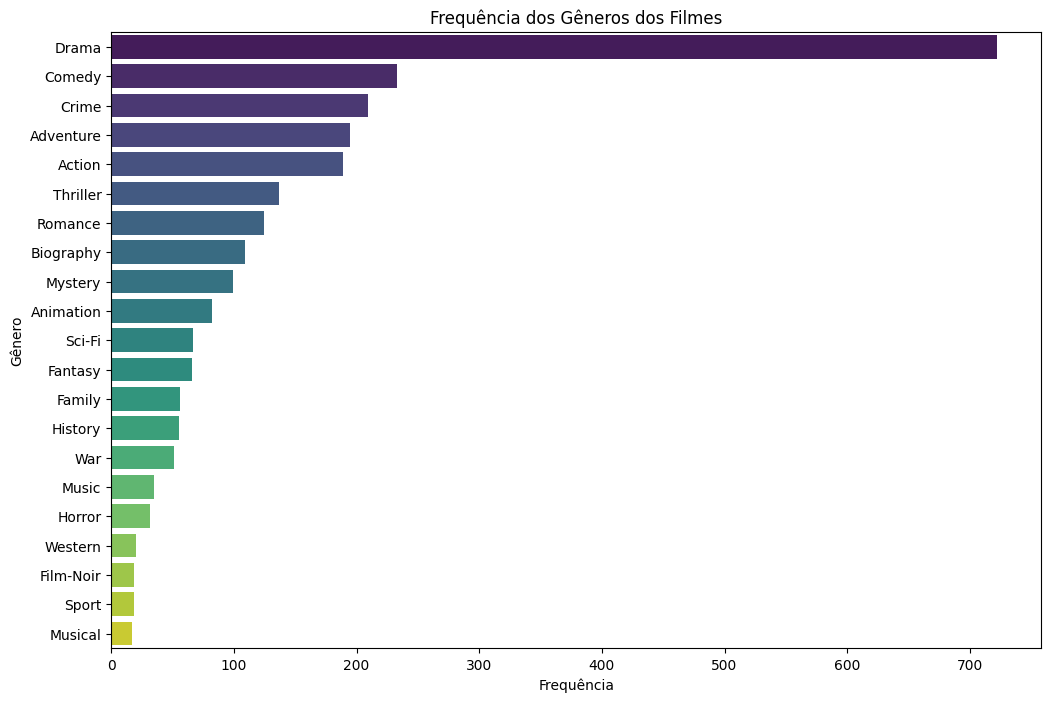

In [26]:
# Explodir os gêneros para contagem
genres = df['Genre'].str.split(', ')
all_genres = [genre for sublist in genres for genre in sublist]
genre_counts = pd.Series(all_genres).value_counts()

plt.figure(figsize=(12, 8))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')
plt.title('Frequência dos Gêneros dos Filmes')
plt.xlabel('Frequência')
plt.ylabel('Gênero')
plt.show()

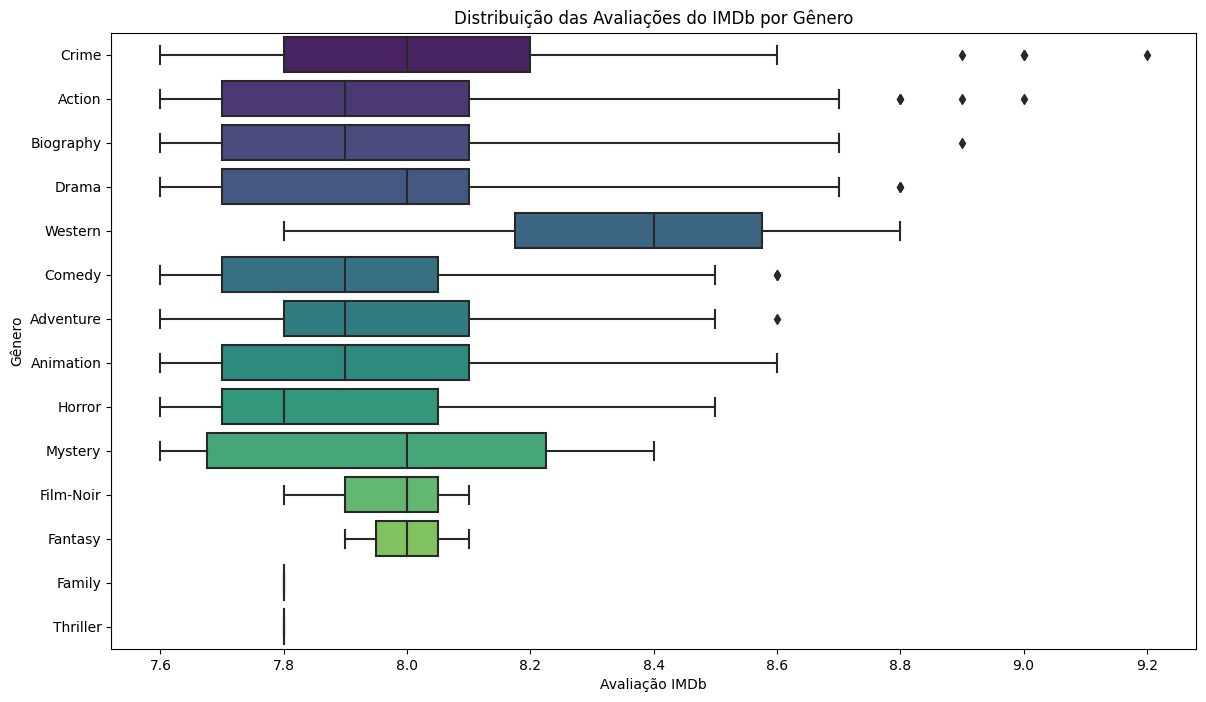

In [27]:
# Criar uma coluna para o gênero principal
df['Primary_Genre'] = df['Genre'].str.split(', ').str[0]

plt.figure(figsize=(14, 8))
sns.boxplot(x='IMDB_Rating', y='Primary_Genre', data=df, palette='viridis')
plt.title('Distribuição das Avaliações do IMDb por Gênero')
plt.xlabel('Avaliação IMDb')
plt.ylabel('Gênero')
plt.show()

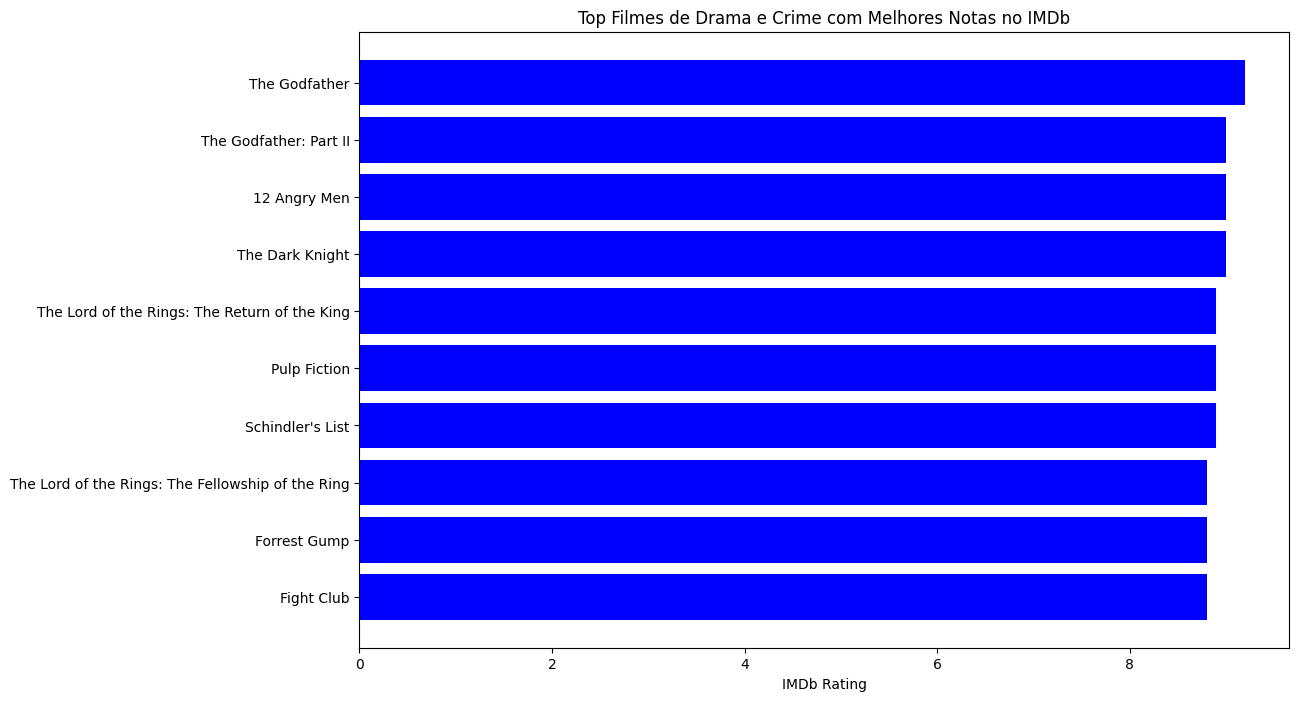

In [28]:
# Filtrando os dados para incluir apenas os gêneros Drama e Crime
filmes_drama_crime = df[(df['Genre'].str.contains('Drama')) | (df['Genre'].str.contains('Crime'))]

# Ordenando os filmes por nota do IMDb em ordem decrescente
filmes_drama_crime = filmes_drama_crime.sort_values(by='IMDB_Rating', ascending=False).head(10)

# Criando o gráfico de barras horizontal
plt.figure(figsize=(12, 8))
plt.barh(filmes_drama_crime['Series_Title'], filmes_drama_crime['IMDB_Rating'], color='blue')
plt.xlabel('IMDb Rating')
plt.title('Top Filmes de Drama e Crime com Melhores Notas no IMDb')
plt.gca().invert_yaxis()  # Inverter a ordem dos filmes para exibir do maior para o menor rating
plt.show()

In [29]:
# Fazendo a seleção da maior avaliação em todo o dataset, The Godfather também é o primeiro
df.sort_values(by='IMDB_Rating', ascending=False).head(1)

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,Primary_Genre
1,The Godfather,1972.0,A,175,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.0,Crime


Para recomendar um filme para uma pessoa desconhecida, um bom critério seria selecionar um filme com alta avaliação IMDb e um gênero popular. Então, tendo como base o que foi construído e apresentado acima, eu recomendaria **The Godfather**, que é uma excelente recomendação com base em sua alta avaliação no IMDb (9.2) e sua classificação em gêneros populares como **Crime** e **Drama**.

#### B - Quais são os principais fatores que estão relacionados com alta expectativa de faturamento de um filme?

##### Correlação entre Variáveis

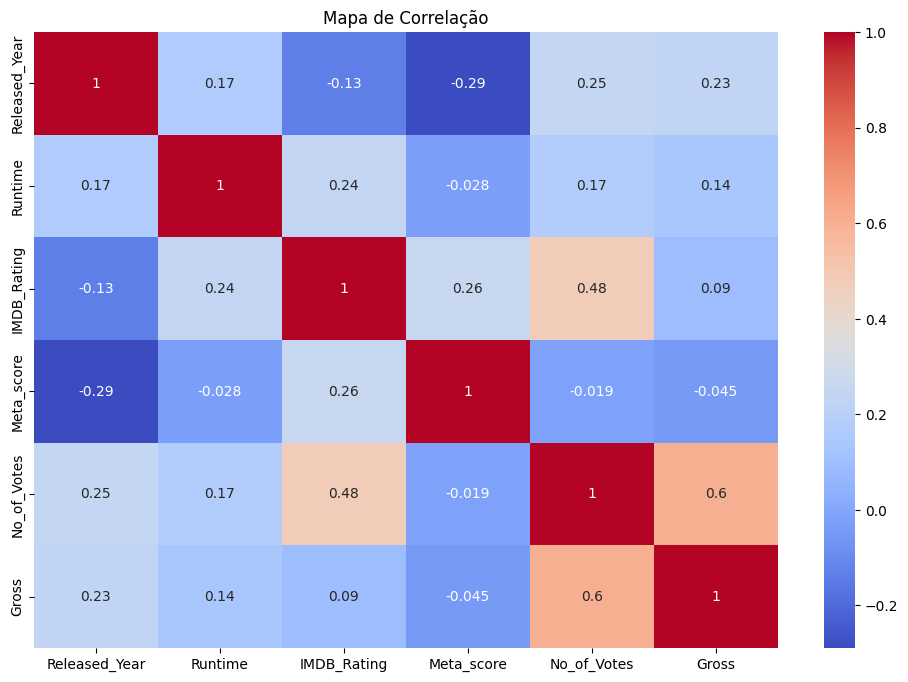

In [30]:
# Selecionar apenas as colunas numéricas
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Calcular a matriz de correlação
correlation_matrix = df[numeric_columns].corr()

# Plotar o heatmap da matriz de correlação
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Mapa de Correlação')
plt.show()

**Com base na análise de correlação, alguns fatores que podem estar relacionados com a expectativa de alto faturamento, são:**

- Número de votos (No_of_Votes)

- Ano de lançamento do filme

- Tempo de duração do filme

**Outro fator que vale ser analisado é se as estrelas que participam do filme podem ser um fator relacionado com o sucesso de bilheteria do filme produzido!**

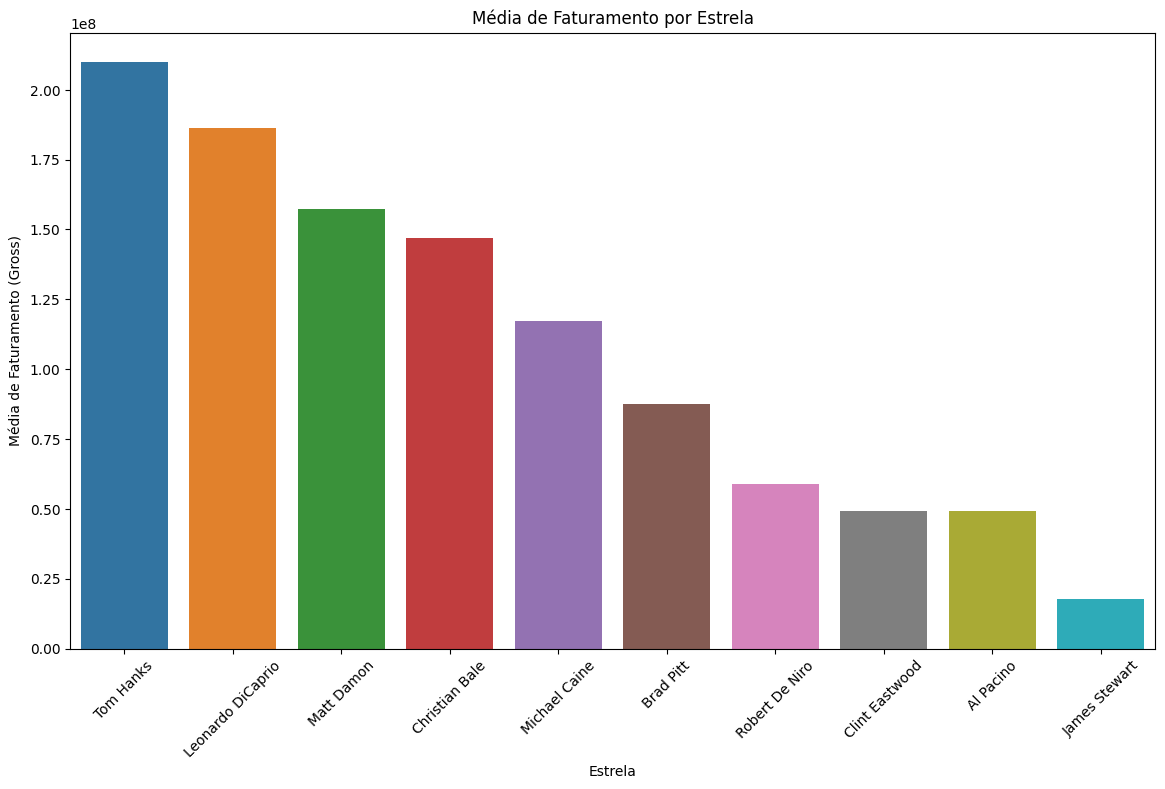

In [31]:
# Combinar todas as estrelas em uma única coluna
df_melted = df.melt(id_vars=['Gross'], value_vars=['Star1', 'Star2', 'Star3', 'Star4'], var_name='Star_Position', value_name='Star')

# Filtrar as estrelas mais frequentes para visualização
top_stars = df_melted['Star'].value_counts().index[:10]

# Filtrar o DataFrame para incluir apenas essas estrelas
df_top_stars = df_melted[df_melted['Star'].isin(top_stars)]

# Calcular a média de faturamento por estrela
avg_gross_by_star = df_top_stars.groupby('Star')['Gross'].mean().sort_values(ascending=False)

# Criar o Bar Plot
plt.figure(figsize=(14, 8))
sns.barplot(x=avg_gross_by_star.index, y=avg_gross_by_star.values)
plt.xticks(rotation=45)
plt.title('Média de Faturamento por Estrela')
plt.xlabel('Estrela')
plt.ylabel('Média de Faturamento (Gross)')
plt.show()

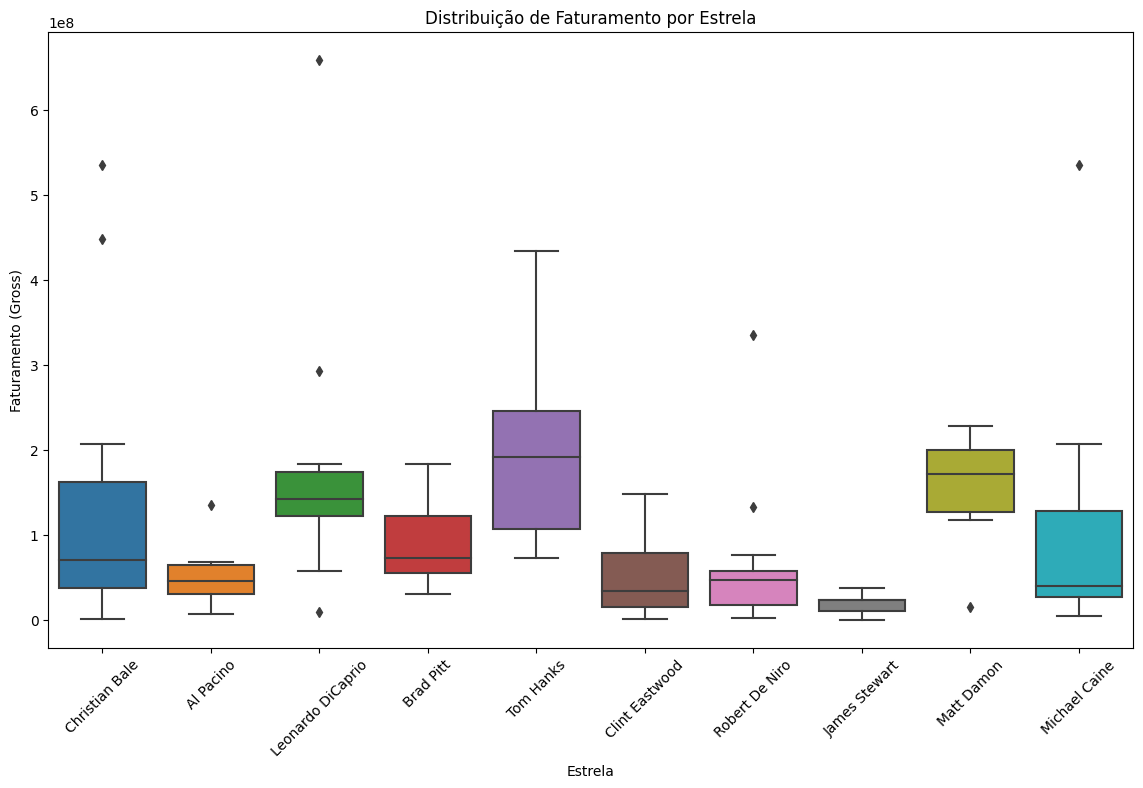

In [32]:
# Criar o Boxplot
plt.figure(figsize=(14, 8))
sns.boxplot(x='Star', y='Gross', data=df_top_stars)
plt.xticks(rotation=45)
plt.title('Distribuição de Faturamento por Estrela')
plt.xlabel('Estrela')
plt.ylabel('Faturamento (Gross)')
plt.show()

##### Através das visualizações construídas, como no gráfico de barras, podemos ver que atores como Tom Hanks, Leonardo DiCaprio e Scarlett Johansson estão associados a filmes com altos faturamentos médios, sugerindo que a presença desses atores pode estar correlacionada com uma maior expectativa de faturamento.

##### Já o box plot podemos ter uma visão mais detalhada da distribuição de faturamento dos filmes para cada estrela:
- Por exemplo, Tom Hanks e Scarlett Johansson não só apresentam altos faturamentos médios, mas também têm uma ampla distribuição, indicando que alguns de seus filmes têm faturamentos extremamente altos.
- Além disso, podemos ver que atores como Al Pacino e James Stewart têm uma distribuição de faturamento mais baixa, indicando que a presença desses atores pode não ser um indicativo tão forte de alta expectativa de faturamento.

##### Sendo assim, as estrelas dos filmes, especialmente aquelas que são conhecidas por suas performances em filmes de alto faturamento, como Tom Hanks, Leonardo DiCaprio e Scarlett Johansson, parecem estar correlacionadas com uma alta expectativa de faturamento.

#### C- Quais insights podem ser tirados com a coluna Overview? É possível inferir o gênero do filme a partir dessa coluna?

In [33]:
# Separar os gêneros em listas
df['Genre'] = df['Genre'].str.split(',')

# Explodir a lista de gêneros para que cada linha contenha apenas um gênero
df = df.explode('Genre').reset_index(drop=True)

# Strip whitespace from genre names
df['Genre'] = df['Genre'].str.strip()

# Criar o TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)

# Aplicar TF-IDF nas descrições
tfidf_matrix = tfidf.fit_transform(df['Overview'].dropna())

# Converter a matriz TF-IDF para um DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

# Adicionar os gêneros ao DataFrame
tfidf_df['Genre'] = df['Genre'].dropna().reset_index(drop=True)

# Agrupar por gênero e calcular a média dos valores TF-IDF para cada palavra
tfidf_genre = tfidf_df.groupby('Genre').mean()

# Função para plotar as visualizações
def plot_genre_visualizations(genre):
    # Texto para a nuvem de palavras
    text = " ".join(df[df['Genre'].str.contains(genre, na=False)]['Overview'].dropna().tolist())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Principais palavras TF-IDF
    top_words = tfidf_genre.loc[genre].sort_values(ascending=False).head(10)

    # Criar subplots
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    
    # Plotar a nuvem de palavras
    ax[0].imshow(wordcloud, interpolation='bilinear')
    ax[0].axis('off')
    ax[0].set_title(f'Nuvem de palavras dos filmes de {genre}', fontsize=16)
    
    # Plotar as principais palavras TF-IDF
    sns.barplot(x=top_words.values, y=top_words.index, ax=ax[1])
    ax[1].set_title(f'Top TF-IDF para filmes de {genre}', fontsize=16)
    ax[1].set_xlabel('TF-IDF Score', fontsize=14)
    ax[1].set_ylabel('Words', fontsize=14)
    
    # Mostrar a figura
    plt.tight_layout()
    plt.show()

# Criar a lista de gêneros únicos
unique_genres = sorted(df['Genre'].unique())

# Criar um widget de dropdown para selecionar o gênero
genre_selector = widgets.Dropdown(
    options=unique_genres,
    description='Gênero:',
    disabled=False,
)

# Usar a função interact para criar a interface interativa
interact(plot_genre_visualizations, genre=genre_selector)

interactive(children=(Dropdown(description='Gênero:', options=('Action', 'Adventure', 'Animation', 'Biography'…

<function __main__.plot_genre_visualizations(genre)>

Criei nuvens de palavras específicas para diferentes gêneros com o objetivo de analisar as palavras e expressões que se destacam em cada um deles. Além disso, realizei uma análise de TF-IDF (Term Frequency-Inverse Document Frequency) para identificar as 10 palavras mais importantes em cada gênero. Para tornar essa análise mais acessível e dinâmica, utilizei a **biblioteca ipywidgets, permitindo a visualização interativa onde é possível selecionar o gênero desejado para visualização.**

**Logo, como podemos perceber, há sim insights a ser retirados da coluna Overview. Segue abaixo:**

1. **Palavras-chave frequentes:**

- A nuvem de palavras destaca termos frequentemente usados nos resumos dos filmes de ação, como "two", "must", "battle", "lead", "save", "family", "team", entre outros. Isso indica os temas e elementos comuns em filmes de ação, como batalhas, equipes, salvamentos e conflitos.

2. **Termos relevantes pelo TF-IDF:** 

- A análise TF-IDF mostra as palavras que são mais distintivas por exemplo, para o gênero "Action" em relação aos demais. Termos como "man", "young", "war", "team", "agent" são altamente representativos dos resumos de filmes de ação.

**E sobre a inferência do gênero a partir da coluna overview:**

- Sim, há a possibilidade de inferir o gênero de um filme a partir da coluna "Overview". Por exemplo, na visualização construída, podemos ver que no gênero Romance, palavras como "love", "wife", e "relationships" se destacam como umas das mais frequentes. Em contraste, no gênero Crime, palavras como "murder", "police", "prison", e "violent" são predominantes. Isso mostra que palavras específicas frequentemente associadas a certos gêneros são repetidamente mencionadas nos resumos dos filmes.

Além disso, a aplicação de outras técnicas de Processamento de Linguagem Natural (NLP) que podem aprimorar significativamente a inferência do gênero. 

Portanto, a coluna "Overview" é uma ferramenta valiosa para inferir o gênero de um filme devido às palavras-chave recorrentes que são características de cada gênero.

**PS: Caso você esteja vendo somente no GitHub (você pode baixar ou usar o notebook no Colab), infelizmente não será possível ver o gráfico interativo (Não é possível ver gráfico interativo no GitHub). Por isso, no repositório construído, há uma imagem(Gráfico_Overview.png) do gráfico interativo para facilitar seu entendimento.**

#### Salvando o dataframe já com os tratamentos feitos para a EDA, com o objetivo de utilizá-lo no Notebook_Model

In [34]:
# Salvar o DataFrame tratado em um arquivo pickle
#df.to_pickle('df.pkl')